In [13]:

import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

import math
import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes
from spectral_cube import LazyMask
from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys
import gc
sys.setrecursionlimit(200000)

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline
from astrodendro.analysis import PPVStatistic


print(astrodendro.__file__)

from matplotlib.patches import Ellipse
import copy
from tqdm import tqdm
import radio_beam

from scipy.optimize import curve_fit
from scipy.optimize import leastsq
#%matplotlib widget
from astropy.convolution import Gaussian1DKernel

/home/ben/miniconda3/bin/python
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
astropy 5.1.dev153+gb740594dc
reproject 0.8
spectral_cube 0.6.1.dev22+g003ef16
/home/ben/.local/lib/python3.8/site-packages/astrodendro/__init__.py


# Part 1: Updates

# Part 8: Dendograms

In [18]:
Names=[1,2,3,4,5,6,7,8,9,10,11,12] #An array for the dendrogram names

In [14]:

#Create a function that uses the dendrogram input to calculate all the quantities, and has the size and linewidth requirements of the Shetty paper
#Requires the computed dendrogram, the data from the line image, the velocity axis, and the data from the Continuum image, as well as metadata for the structures
#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]
#Continuum is in Jansky/Beam, Line data should have the unit specified in the metadata as 'data_unit'

def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata,ColD = True):
    
    SizeA,SigmaA,LuminA,CDA,SIDS,MOM0_FLUX = [[],[],[],[]],[[],[],[],[]],[[],[]],[[],[]],[[],[]],[[],[]]
    #print(metadata,np.shape(LineData),np.shape(DataVel))
    for t in Dendrogram.all_structures: 

        I = t.indices()
        Cont = True
        if t.is_branch:
                if t.parent==None:
                    Cont=True
                else:
                    Cont = True

        if(Cont):
            s = PPVStatistic(t,metadata=metadata)
            #print((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6)
            #if((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6<18 and (float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6>4.3/5 and (float(s.v_rms/u.km*u.s))>.01):
            #if((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6<18 and (float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6>4.3/5 and (float(s.v_rms/u.km*u.s))>.01):
            if((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6>.6 and (float(s.v_rms/u.km*u.s))>.01):
            #?
            #if((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6>.9 and (float(s.v_rms/u.km*u.s))>.01):

                nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
                v_IWM = np.nansum(LineData[I]*(DataVel[I[0]])/u.km*u.s)/np.nansum(LineData[I])
                sig_Sh = np.sqrt(np.nansum(LineData[I]*((DataVel[I[0]])/u.km*u.s-v_IWM)**2)/np.nansum(LineData[I])) 

                #The flux from the continuum
                #Convert to Jansky from Jansky per beam:
                if(ColD ==True):
                    Cont_Flux=0

                    proj = tuple(set(zip(*tuple(I[i] for i in [1,2]))))
                    for lmi in range(len(proj)):

                        Cont_Flux+=ContData[proj[lmi]]
                    Cont_Flux=Cont_Flux/(metadata['beam_area_ratioc']*(2*np.sqrt(2*np.log(2))))*u.pix**2*u.beam/u.beam*u.Jy#SHould be input as Jansky /beam and will be converted to Jansky, then to unitless. The beam is changed from FWHM to Gaussian
                    Dust_Column = Flux_to_Mass(Cont_Flux)*Num_per_kg/((s.radius*np.pi/180*8.178*10**-3/u.deg)**2*(3.086*10**24)**2)/np.pi*(1.989*10**30*u.kg/u.M_sun)/u.kg
                else:
                    Dust_Column=0
                if(str(Dust_Column) == str(np.nan) or str(Dust_Column)==str(np.inf)):
                    Dust_Column=0
                lum = Flux_to_Lum(s.flux)
                s_flux = s.flux

                Index = tuple(I[i] for i in [0,1,2])
                K_Km_s_Flux=np.nansum(LineData[Index]*metadata["velocity_scale"])#Find the total flux from the structures in K km/s, assuming the input data is in K as it should be, 

                if(t.is_leaf):

                    SizeA[0].append((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))) #define size as astrodendro
                    SigmaA[0].append((float(s.v_rms/u.km*u.s)))#
                    CDA[0].append(float(Dust_Column))
                    LuminA[0].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[0].append(float(t.idx))
                    MOM0_FLUX[0].append(float(K_Km_s_Flux*u.s/u.km))
                if(t.is_branch	):

                    SizeA[1].append((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))) #define size as astrodendro
                    SigmaA[1].append((float(s.v_rms/u.km*u.s)))#
                    CDA[1].append(float(Dust_Column))
                    LuminA[1].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[1].append(float(t.idx))
                    MOM0_FLUX[1].append(float(K_Km_s_Flux*u.s/u.km))
    SizeA[0] = np.array(SizeA[0],dtype=type(1.))
    SizeA[1] = np.array(SizeA[1],dtype=type(1.))
    SizeA[2] = np.array(SizeA[2],dtype=type(1.))
    SizeA[3] = np.array(SizeA[3],dtype=type(1.))
    SigmaA[0] = np.array(SigmaA[0],dtype=type(1.))
    SigmaA[1] = np.array(SigmaA[1],dtype=type(1.))
    SigmaA[2] = np.array(SigmaA[2],dtype=type(1.))
    SigmaA[3] = np.array(SigmaA[3],dtype=type(1.))
    CDA[0] = np.array(CDA[0],dtype=type(1.))
    CDA[1] = np.array(CDA[1],dtype=type(1.))
    LuminA[0] = np.array(LuminA[0],dtype=type(1.))
    LuminA[1] = np.array(LuminA[1],dtype=type(1.))
    SIDS[0] = np.array(SIDS[0],dtype=type(1.))
    SIDS[1] = np.array(SIDS[1],dtype=type(1.))
    MOM0_FLUX[0] = np.array(MOM0_FLUX[0],dtype=type(1.))
    MOM0_FLUX[1] = np.array(MOM0_FLUX[1],dtype=type(1.))
    
    return np.array(SizeA),np.array(SigmaA),np.array(CDA),np.array(LuminA),np.array(SIDS),np.array(MOM0_FLUX)

#Make a function to make an image 

#Data to plot, minimum of color bar, maximum, WCS projection for coords, and position of the image in the larger figure
def Make_Plot(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
    pylab.ylabel('Declination',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=0.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
def Make_Plot_Anno(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show,pos1,pos2):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
    pylab.ylabel('Declination',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(pos1,pos2),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
        
        
#Put this up here for the column density map
def Flux_to_Mass(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    L = 4*np.pi*(8.178*10**-3*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    
    a_850 = 6.7*10**19*u.erg/u.s/u.Hz/u.M_sun #6.7+-1.7
    
    M_mol = L/a_850#Just in Solar mass*1.989*10**30*u.kg/u.M_sun #Determines mass of the cont for 850 in kg
    return M_mol
def Flux_to_Lum(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    L = 4*np.pi*(8.178*10**-3*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    return L


def Find_Pixel_D(flux,metadata,sub = "Nope"):
    center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
    
    x,y = [metadata["Cwcs"].world_to_pixel(center)[0],(metadata["Cwcs"].world_to_pixel(center)[1])]
    d0 = 8.178 *10**-3*u.Mpc #mpc
    D_Es = np.empty(np.shape(flux))
    for lmi in range(len(flux)):
        for lmj in range(len(flux[lmi])):
            #Find the distance to earth from every pixel
            D_Es[lmi][lmj] = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((lmj-x)**2+(lmi-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )/u.Mpc#Has to be unitless so it saves, so bring the unit back when it is loaded
            
    #print(D_Es)
    if(sub=="Nope"):
        np.save("Pixel_D",D_Es)
    else:
        np.save(sub,D_Es)

#path ="Noise_Matched_CMZ_CO_3_2_355_005.fits"
#cmz_cube=SpectralCube.read(path)
#Find_Pixel_D(cmz_cube.moment0().hdu.data,metadata)

#Return a cropped cube for some ra and dec, also crops the velocity axis if needed (0 for no crop)
def Crop(cube,WCS,Np1,Np2,BadVel,D2):
    NraDP1 = [int(WCS.world_to_pixel(Np1)[0]),int(WCS.world_to_pixel(Np1)[1])]
    NraDP2 = [int(WCS.world_to_pixel(Np2)[0]),int(WCS.world_to_pixel(Np2)[1])]
    if(D2==False):
        return cube[BadVel:np.shape(cube)[0]-BadVel,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]
    if(D2==True):
        return cube[NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]
    
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,1,True)
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,2,True)

CMZ_CO 3-2_Abs_New ['CMZ_HCOp 1-0_Abs_New', 'CMZ_HCN 1-0_Abs_New', 'CMZ_H13CN 1-0_Abs_New', 'CMZ_H13CO+ 1-0_Abs_New', 'CMZ_CO 3-2_Abs_New', 'CMZ_CO 3-2_Abs', 'CMZ_CO 3-2_Abs', 'CMZ_CO 3-2_Abs']
OG noise =  0.00802031832999669 K
NGC_Matched noise =  0.0212793941403859 K


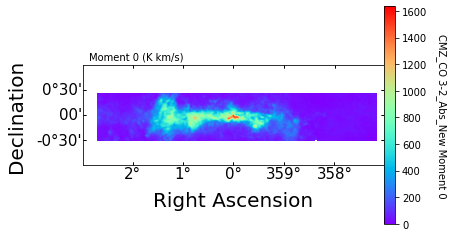

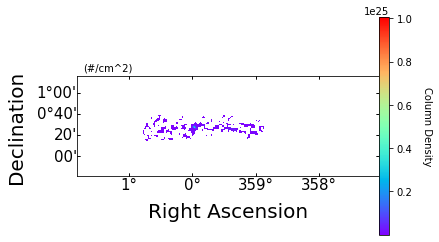

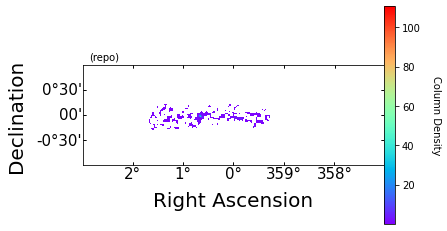

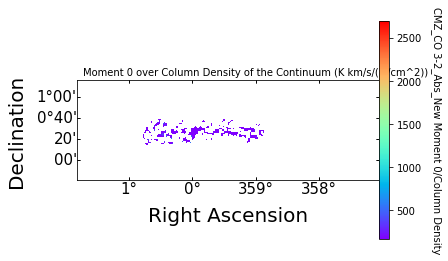

dend number 0
(20559,)
(100, 475, 1427)
dend number 1
(11986,)
(100, 475, 1427)
dend number 2
(9189,)
(100, 475, 1427)
dend number 3
(7681,)
(100, 475, 1427)
dend number 4
(6659,)
(100, 475, 1427)
done


In [5]:

#CO 
#
#
#For the cube that has not been rotated
#
#
Num=4
Ram_Limiter=.5#What percent of the cube my ram can handle
#NGCCO32_Noise = 0.115*u.K
NGCCO32_Noise=0.6411655169449448*u.K

LineN="CMZ_CO-J3-2_New"
Name = "CMZ_CO 3-2_Abs_New"
name = "CMZ_CO_3_2_CM_Contours_Abs2_New.jpeg"


Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2

try:
    Names= list(np.load("Names_CMZ_New.npy"))
except:
    Names= list(np.load("Names_CMZ.npy"))
Names[Num] = Name

np.save("Names_CMZ_New",Names)

print(Name,Names)


#path ="Noise_Matched_CMZ_CO_3_2_355_005_New.fits"#"Noise_Matched_"+'CMZ_CO_3_2_358_002.fits'
path ="CMZ_CO_3_2_355_005_New.fits"#"Noise_Matched_"+'CMZ_CO_3_2_358_002.fits'

#path ='CMZ_CO_3_2_355_005_New.fits'
pathog='CMZ_CO_3_2_355_005_New.fits'
pathCont = 'CMZ_Continuum_Splice.fits'



pathog="CMZ_Spliced_Reprojected_Whole_HCOp_10.fits"#With Gauss

pathCont = 'CMZ_Continuum_Splice.fits'


#Make subcube

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True
Qp = Qp[:,:,:]#Get rid of the excess nan parts
Q = Qp.to(u.K)#Jy to Kelvin
sc = Q.unmasked_copy()
scW = sc.wcs[:][:][0]
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]

scF = scn[:,:,:]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat[:,:,:]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)z



Qpog = SpectralCube.read(pathog).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qpog.allow_huge_operations=True
Qog = Qpog.to(u.K)#Jy to Kelvin
scog = Qog.unmasked_copy()


mog = (np.nanstd(scog.hdu.data[0,:,:])) #Noise K
Non_nan=((sc.hdu.data[0,:,:]>0)  | (sc.hdu.data[0,:,:]<0 ))

m = (np.nanstd(sc.hdu.data[0,:,:],where= Non_nan)) #Noise K


print("OG noise = ",mog,"K")
print("NGC_Matched noise = ",m,"K")
del scog
del Qog
del Qpog

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
#m=.115


#Put this up here for the column density map
metadata = {}
metadata["distance"] = 8.178*10**-3*u.Mpc
arc_per_pix_yc =  abs(scContW.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scContW.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scContW.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scContW.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scContW.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
header = scF.hdu.header
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
Continuum_Data  =scContW.hdu.data
scWCS = scF.wcs[:][:][0]

moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



######Moment 0 for both
######and cont
Make_Plot((Name+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number




rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
   
bp = np.where(cSD<=.1*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)
Continuum_Data[bp] = np.nan

cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan

Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)

Make_Plot("Column Density","(repo)",scContW.hdu.data,float(np.nanmin(scContW.hdu.data)),float(np.nanmax(scContW.hdu.data)),scContW.wcs,1,1,1,True)


Make_Plot((Name+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)





#Calculate many dendrograms
for lmi in range(5):
    print("dend number",lmi)
    #Range from min SNR of 3 to 8, and keep the delta/snr ratio at 1/5
    d = astrodendro.Dendrogram.compute(datn,min_delta=m*(1+lmi),min_value=m*(5+lmi*5),min_npix=beam_area_ratio.value) #The main culprit
    print(np.shape(d))
    print(np.shape(datn))
    dName = Name+"Dendrogram_Gauss_SNR_"+str((3+lmi))+".fits"
    #Had to change astropy so overwrite is always true
    d.save_to(dName)
    
    #d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit
    #d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value*3) #The main culprit

print("done")

noise =  0.0212793941403859 K
(20559,)
(100, 475, 1427)
(17776,)


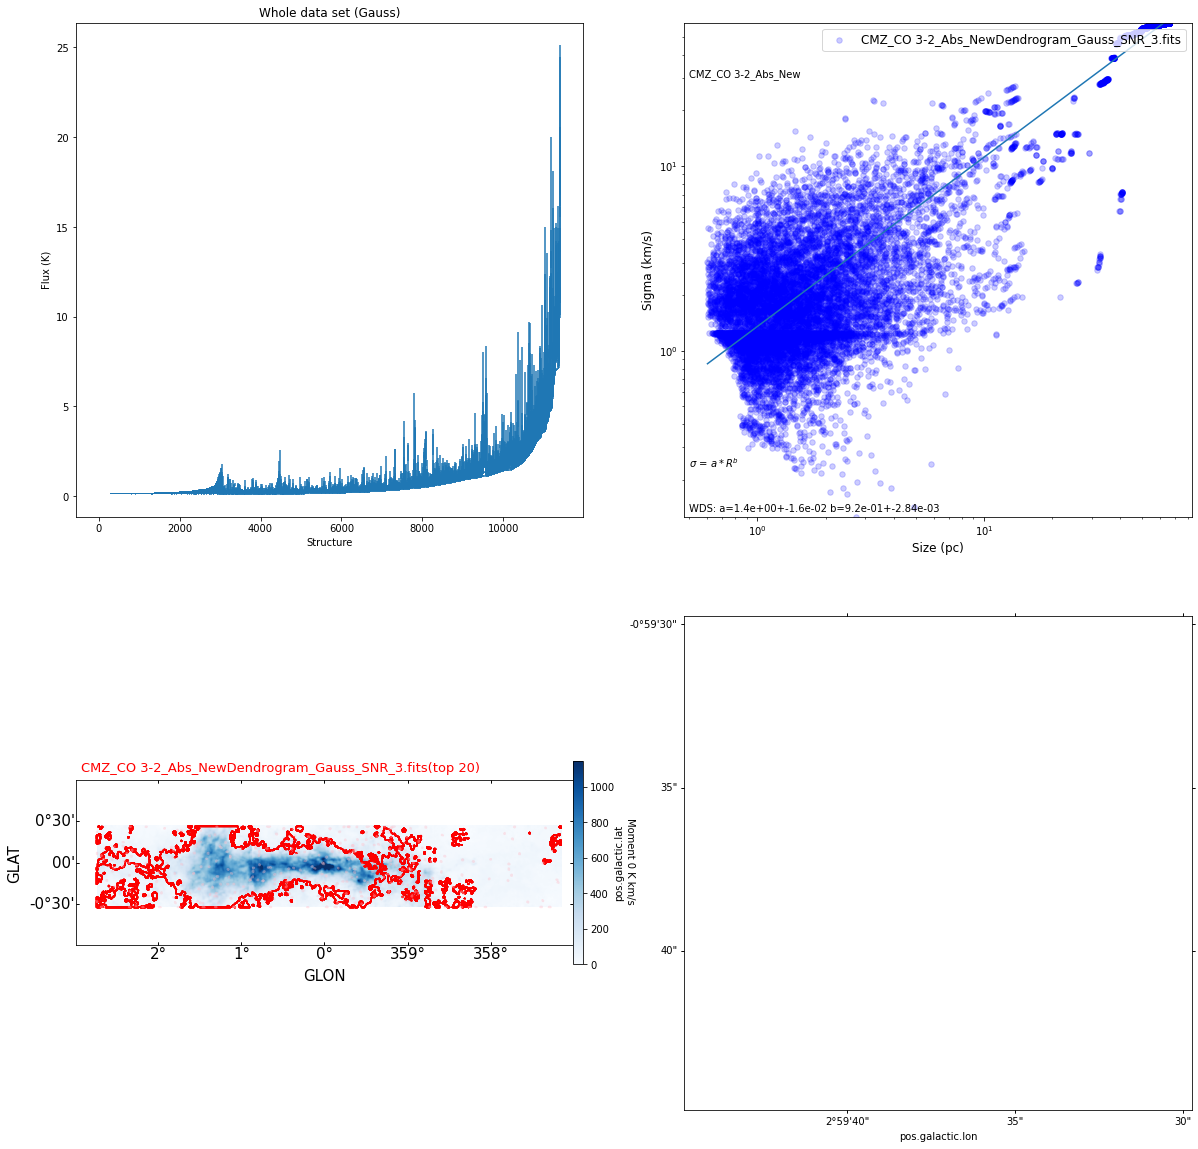

[20373. 20487.]
(11986,)
(100, 475, 1427)


In [ ]:

#CO 
#
#
#For the cube that has not been rotated
#
#
Num=4
#Ram_Limiter=.5#What percent of the cube my ram can handle
#NGCCO32_Noise = 0.115*u.K
NGCCO32_Noise=0.6411655169449448*u.K

LineN="CMZ_CO-J3-2_New"
Name = "CMZ_CO 3-2_Abs_New"
name = "CMZ_CO_3_2_CM_Contours_Abs2_New.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2
#Make subcube
Ram_Limiter=.5#What percent of the cube my ram can handle


#path ="Noise_Matched_CMZ_CO_3_2_355_005_New.fits"#"Noise_Matched_"+'CMZ_CO_3_2_358_002.fits'
path ="CMZ_CO_3_2_355_005_New.fits"#"Noise_Matched_"+'CMZ_CO_3_2_358_002.fits'

#path ='CMZ_CO_3_2_355_005_New.fits'
pathog='CMZ_CO_3_2_355_005_New.fits'
pathCont = 'CMZ_Continuum_Splice.fits'

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True
Qp = Qp[:,:,:]#Get rid of the excess nan parts
Q = Qp.to(u.K)#Jy to Kelvin
sc = Q.unmasked_copy()
scW = sc.wcs[:][:][0]
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scF = scn[:,:,:]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat[:,:,:]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)z




Non_nan=((sc.hdu.data[0,:,:]>0)  | (sc.hdu.data[0,:,:]<0 ))

m = (np.nanstd(sc.hdu.data[0,:,:],where= Non_nan)) #Noise K



print("noise = ",m,"K")

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])

scContW = scCont.reproject(scF.moment0().header)
metadata = {}
metadata["distance"] = 8.178*10**-3*u.Mpc
arc_per_pix_yc =  abs(scContW.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scContW.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scContW.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scContW.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scContW.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
header = scF.hdu.header
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*(8.178*10**-3))**2#mpc^2/pix^2
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0
Continuum_Data  =scContW.hdu.data


for lmi in range(5):
    dName = Name+"Dendrogram_Gauss_SNR_"+str((3+lmi))+".fits"
    
    d=astrodendro.Dendrogram.load_from(dName)
    print(np.shape(d))
    print(np.shape(datn))
    vel,RA,Dec = scF.world[:,0,0]
    Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX = Dendro_Arrays(d,datn,vel,Continuum_Data,metadata)
    
    ##Analyze dendograms


    fig = plt.figure(1,figsize=(20,20))
    
    axAlpha = pylab.subplot(2, 2, 1)
    axDelta = pylab.subplot(2, 2, 3,projection=scF.moment0().wcs)
    axDelta2 = pylab.subplot(2, 2, 4,projection=scF.moment0().wcs)
    axDat = pylab.subplot(2, 2, 2)

    p1=d.plotter()
    p1.plot_tree(axAlpha)
    axAlpha.set_xlabel("Structure")
    axAlpha.set_ylabel("Flux (K)")
    axAlpha.set_title("Whole data set (Gauss)")

    #Plot contours for the top clusters
    scCropped =scF.moment0().hdu.data
    imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )
    Rcon = np.concatenate((Rads[0],Rads[1]))
    
    nth = sorted(Rcon)[len(Rcon)-30]
    G1 = True
    SIDScon=np.concatenate((SIDS[0],SIDS[1]))
    for n in range(len(Rcon)):
        if(Rcon[n]>=nth):
            if(G1):
                G1=False
                p1.plot_contour(axDelta, structure=int(SIDScon[n]), lw=1, colors='red',label="Higest Size",alpha=.4)
            else:
                p1.plot_contour(axDelta, structure=int(SIDScon[n]), lw=1, colors='red',alpha=.4)
    nth = sorted(Rcon)[300]
    G1 = True
    SIDScon=np.concatenate((SIDS[0],SIDS[1]))
    for n in range(len(Rcon)):
        if(Rcon[n]<=nth):
            if(G1):
                G1=False
                p1.plot_contour(axDelta, structure=int(SIDScon[n]), lw=1, colors='pink',label="Lowest Size",alpha=.4)
            else:
                p1.plot_contour(axDelta, structure=int(SIDScon[n]), lw=1, colors='pink',alpha=.4)
                
    RA = axDelta.coords[0]                                                                  # 
    Dec = axDelta.coords[1]
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    axDelta.set_xlabel('GLON',fontsize=15,labelpad=1)                               
    axDelta.set_ylabel('GLAT',fontsize=15,labelpad=1)
    axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(imBeta,fraction=0.02,pad=0.00,ax=axDelta)                                     
    cb.set_label(label=("Moment 0 K km/s "),fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    axDelta.annotate(s=(dName+"(top 20)"),fontsize=13,xy=(.01,1.05),xycoords="axes fraction",c="red")  
    
    #Same but for no gauss
    



    pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

    #Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]

    def func(R,a,b):
        return a*R**(b)

    Scon = np.concatenate((Sigmas[0],Sigmas[1]))
    
    print(np.shape(Rcon))
    poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)
    xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)

    ysCon=func(xs,poptCon[0],poptCon[1])

    
    xpcon = axDat.scatter(Rcon*10**6,Scon,label=dName,s=30,alpha=.2,color="blue")
    p = axDat.plot(xs,ysCon)
    





    st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
    axDat.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

    axDat.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
    axDat.set_yscale('log')
    axDat.set_xscale('log')
    axDat.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
    axDat.set_xlabel("Size (pc)",fontsize=12)
    axDat.set_ylabel("Sigma (km/s)",fontsize=12)
    axDat.legend(prop={'size': 12},loc="upper right")
    axDat.annotate(s=Name,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


    pylab.show()



    
    print(SIDScon[len(SIDScon)-3:len(SIDScon)-1])



In [16]:

#CO 
#
#
#For the cube that has not been rotated
#
#
Num=4
#Ram_Limiter=.5#What percent of the cube my ram can handle
#NGCCO32_Noise = 0.115*u.K
NGCCO32_Noise=0.6411655169449448*u.K

LineN="CMZ_CO-J3-2_New"
Name = "CMZ_CO 3-2_Abs_New"
name = "CMZ_CO_3_2_CM_Contours_Abs2_New.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2
#Make subcube
Ram_Limiter=.5#What percent of the cube my ram can handle


#path ="Noise_Matched_CMZ_CO_3_2_355_005_New.fits"#"Noise_Matched_"+'CMZ_CO_3_2_358_002.fits'
path ="CMZ_CO_3_2_355_005_New.fits"#"Noise_Matched_"+'CMZ_CO_3_2_358_002.fits'

#path ='CMZ_CO_3_2_355_005_New.fits'
pathog='CMZ_CO_3_2_355_005_New.fits'
pathCont = 'CMZ_Continuum_Splice.fits'

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True
Qp = Qp[:,:,:]#Get rid of the excess nan parts
Q = Qp.to(u.K)#Jy to Kelvin
sc = Q.unmasked_copy()
scW = sc.wcs[:][:][0]
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scF = scn[:,:,:]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat[:,:,:]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)z




Non_nan=((sc.hdu.data[0,:,:]>0)  | (sc.hdu.data[0,:,:]<0 ))

m = (np.nanstd(sc.hdu.data[0,:,:],where= Non_nan)) #Noise K



print("noise = ",m,"K")

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])

scContW = scCont.reproject(scF.moment0().header)
metadata = {}
metadata["distance"] = 8.178*10**-3*u.Mpc
arc_per_pix_yc =  abs(scContW.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scContW.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scContW.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scContW.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scContW.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
header = scF.hdu.header
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*(8.178*10**-3))**2#mpc^2/pix^2
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0
Continuum_Data  =scContW.hdu.data


for lmi in range(1,5):
    dName = Name+"Dendrogram_Gauss_SNR_"+str((3+lmi))+".fits"
    
    d=astrodendro.Dendrogram.load_from(dName)
    print(np.shape(d))
    print(np.shape(datn))
    vel,RA,Dec = scF.world[:,0,0]
    Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX = Dendro_Arrays(d,datn,vel,Continuum_Data,metadata)
    
    ##Analyze dendograms


    fig = plt.figure(1,figsize=(20,20))
    
    axAlpha = pylab.subplot(2, 2, 1)
    axDelta = pylab.subplot(2, 2, 3,projection=scF.moment0().wcs)
    axDelta2 = pylab.subplot(2, 2, 4,projection=scF.moment0().wcs)
    axDat = pylab.subplot(2, 2, 2)

    p1=d.plotter()
    p1.plot_tree(axAlpha)
    axAlpha.set_xlabel("Structure")
    axAlpha.set_ylabel("Flux (K)")
    axAlpha.set_title("Whole data set (Gauss)")

    #Plot contours for the top clusters
    scCropped =scF.moment0().hdu.data
    imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )
    Rcon = np.concatenate((Rads[0],Rads[1]))
    
    nth = sorted(Rcon)[len(Rcon)-20]
    G1 = True
    SIDScon=np.concatenate((SIDS[0],SIDS[1]))
    for n in range(len(Rcon)):
        if(Rcon[n]>=nth):
            if(G1):
                G1=False
                p1.plot_contour(axDelta, structure=int(SIDScon[n]), lw=1, colors='red',label="Higest Size",alpha=.4)
            else:
                p1.plot_contour(axDelta, structure=int(SIDScon[n]), lw=1, colors='red',alpha=.4)
    nth = sorted(Rcon)[20]
    G1 = True
    SIDScon=np.concatenate((SIDS[0],SIDS[1]))
    for n in range(len(Rcon)):
        if(Rcon[n]<=nth):
            if(G1):
                G1=False
                p1.plot_contour(axDelta, structure=int(SIDScon[n]), lw=1, colors='yellow',label="Lowest Size",alpha=1)
            else:
                p1.plot_contour(axDelta, structure=int(SIDScon[n]), lw=1, colors='yellow',alpha=1)
                
    RA = axDelta.coords[0]                                                                  # 
    Dec = axDelta.coords[1]
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    axDelta.set_xlabel('GLON',fontsize=15,labelpad=1)                               
    axDelta.set_ylabel('GLAT',fontsize=15,labelpad=1)
    axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(imBeta,fraction=0.02,pad=0.00,ax=axDelta)                                     
    cb.set_label(label=("Moment 0 K km/s "),fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    axDelta.annotate(s=(dName+"(top 20)"),fontsize=13,xy=(.01,1.05),xycoords="axes fraction",c="red")  
    
    #Same but for no gauss
    



    pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

    #Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]

    def func(R,a,b):
        return a*R**(b)

    Scon = np.concatenate((Sigmas[0],Sigmas[1]))
    
    print(np.shape(Rcon))
    poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)
    xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)

    ysCon=func(xs,poptCon[0],poptCon[1])

    
    xpcon = axDat.scatter(Rcon*10**6,Scon,label=dName,s=30,alpha=.2,color="blue")
    p = axDat.plot(xs,ysCon)
    





    st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
    axDat.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

    axDat.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
    axDat.set_yscale('log')
    axDat.set_xscale('log')
    axDat.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
    axDat.set_xlabel("Size (pc)",fontsize=12)
    axDat.set_ylabel("Sigma (km/s)",fontsize=12)
    axDat.legend(prop={'size': 12},loc="upper right")
    axDat.annotate(s=Name,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


    pylab.show()



    
    print(SIDScon[len(SIDScon)-3:len(SIDScon)-1])



noise =  0.0212793941403859 K
(11986,)
(100, 475, 1427)


KeyboardInterrupt: 